In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'pos'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6793256580621939 	 Validation loss: 0.675892174243927 	 
  1%|          | 574/57400 [00:06<09:21, 101.21it/s]
Epoch 2 	 Training loss: 0.6622331018854932 	 Validation loss: 0.6556266323994782 	 
  2%|▏         | 1148/57400 [00:12<09:05, 103.20it/s]
Epoch 3 	 Training loss: 0.651159875380453 	 Validation loss: 0.6487178469108323 	 
  3%|▎         | 1722/57400 [00:18<09:13, 100.66it/s]
Epoch 4 	 Training loss: 0.6438339609094613 	 Validation loss: 0.6409499524003368 	 
  4%|▍         | 2296/57400 [00:24<09:18, 98.62it/s]
Epoch 5 	 Training loss: 0.6373847349180162 	 Validation loss: 0.6335692314778344 	 
  5%|▌         | 2870/57400 [00:30<08:58, 101.18it/s]
Epoch 6 	 Training loss: 0.6308016271333661 	 Validation loss: 0.6306039913225983 	 
  6%|▌         | 3444/57400 [00:36<08:59, 100.08it/s]
Epoch 7 	 Training loss: 0.6242534389479235 	 Validation loss: 0.6285636243173631 	 
  7%|▋         | 4018/57400 [00:42<08:34, 103.67it/s]
Epoch 8 	 Training loss: 0.6187

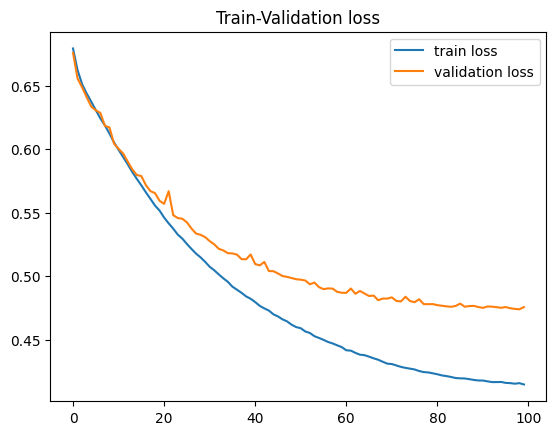

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7091836734693877, 'precision': 0.7091836734693877, 'f1': 0.7091836734693878, 'accuracy': 0.7091836734693877}
MALE {'recall': 0.8046875, 'precision': 0.8046875, 'f1': 0.8046875, 'accuracy': 0.8046875}
FEMALE {'recall': 0.6175, 'precision': 0.6175, 'f1': 0.6175, 'accuracy': 0.6175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.577020202020202, 'precision': 0.577020202020202, 'f1': 0.577020202020202, 'accuracy': 0.577020202020202}
MALE {'recall': 0.6715328467153284, 'precision': 0.6715328467153284, 'f1': 0.6715328467153284, 'accuracy': 0.6715328467153284}
FEMALE {'recall': 0.47506561679790027, 'precision': 0.47506561679790027, 'f1': 0.47506561679790027, 'accuracy': 0.47506561679790027} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5932203389830508, 'precision': 0.5932203389830508, 'f1': 0.5932203389830508, 'accuracy': 0.5932203389830508}
MALE {'recall': 0.6868686868686869, 'precision': 0.6

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6796356401169341 	 Validation loss: 0.6767560829550533 	 
  1%|          | 574/57400 [00:06<09:25, 100.46it/s]
Epoch 2 	 Training loss: 0.6638543123982925 	 Validation loss: 0.6533164917412451 	 
  2%|▏         | 1148/57400 [00:12<09:09, 102.28it/s]
Epoch 3 	 Training loss: 0.6498666076502319 	 Validation loss: 0.642644721572682 	 
  3%|▎         | 1722/57400 [00:18<09:16, 99.96it/s]
Epoch 4 	 Training loss: 0.642200197492327 	 Validation loss: 0.636301553855508 	 
  4%|▍         | 2296/57400 [00:24<09:05, 101.05it/s]
Epoch 5 	 Training loss: 0.6363381190997798 	 Validation loss: 0.6307701518980123 	 
  5%|▌         | 2870/57400 [00:31<08:56, 101.55it/s]
Epoch 6 	 Training loss: 0.6296195773089804 	 Validation loss: 0.6240763300556248 	 
  6%|▌         | 3444/57400 [00:37<08:57, 100.33it/s]
Epoch 7 	 Training loss: 0.6233897931899759 	 Validation loss: 0.6197622923527734 	 
  7%|▋         | 4018/57400 [00:43<08:46, 101.33it/s]
Epoch 8 	 Training loss: 0.61775

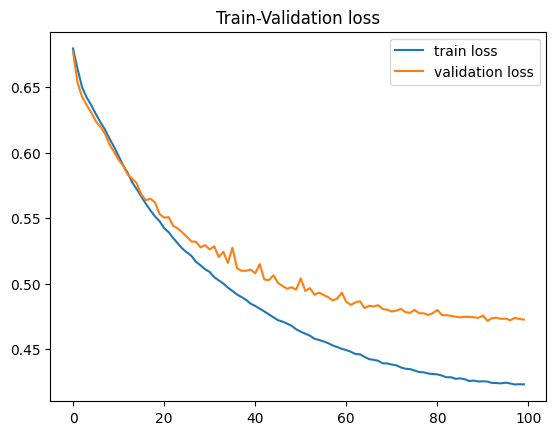

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7270408163265306, 'precision': 0.7270408163265306, 'f1': 0.7270408163265306, 'accuracy': 0.7270408163265306}
MALE {'recall': 0.8125, 'precision': 0.8125, 'f1': 0.8125, 'accuracy': 0.8125}
FEMALE {'recall': 0.645, 'precision': 0.645, 'f1': 0.645, 'accuracy': 0.645} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5946969696969697, 'precision': 0.5946969696969697, 'f1': 0.5946969696969697, 'accuracy': 0.5946969696969697}
MALE {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}
FEMALE {'recall': 0.4776902887139108, 'precision': 0.4776902887139108, 'f1': 0.4776902887139108, 'accuracy': 0.4776902887139108} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5997392438070405, 'precision': 0.5997392438070405, 'f1': 0.5997392438070405, 'accuracy': 0.5997392438070405}
MALE {'recall': 0.6742424242424242, 'precision': 0.6742424242424242,

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6772042655155633 	 Validation loss: 0.6694866267301268 	 
  1%|          | 574/57400 [00:05<09:07, 103.72it/s]
Epoch 2 	 Training loss: 0.659175341968337 	 Validation loss: 0.6563467706664133 	 
  2%|▏         | 1148/57400 [00:11<08:51, 105.82it/s]
Epoch 3 	 Training loss: 0.6501078561000292 	 Validation loss: 0.6476682475057699 	 
  3%|▎         | 1722/57400 [00:17<09:03, 102.41it/s]
Epoch 4 	 Training loss: 0.6434284266902179 	 Validation loss: 0.6418673214265855 	 
  4%|▍         | 2296/57400 [00:23<08:58, 102.33it/s]
Epoch 5 	 Training loss: 0.6368507184218031 	 Validation loss: 0.6340400071467384 	 
  5%|▌         | 2870/57400 [00:29<08:38, 105.27it/s]
Epoch 6 	 Training loss: 0.6298494056542161 	 Validation loss: 0.6287552583015571 	 
  6%|▌         | 3444/57400 [00:35<08:41, 103.55it/s]
Epoch 7 	 Training loss: 0.6226115419889576 	 Validation loss: 0.6221570301864107 	 
  7%|▋         | 4018/57400 [00:42<08:45, 101.67it/s]
Epoch 8 	 Training loss: 0.61

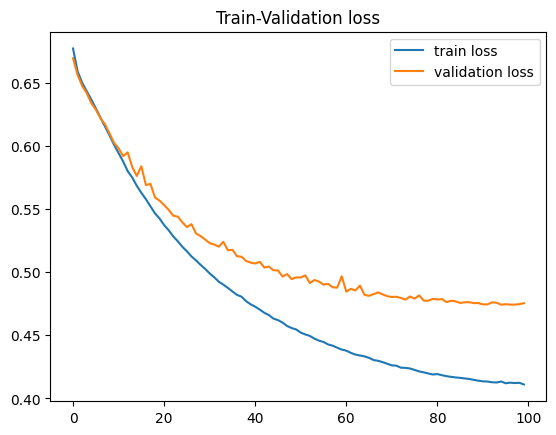

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7334183673469388, 'precision': 0.7334183673469388, 'f1': 0.7334183673469389, 'accuracy': 0.7334183673469388}
MALE {'recall': 0.8359375, 'precision': 0.8359375, 'f1': 0.8359375, 'accuracy': 0.8359375}
FEMALE {'recall': 0.635, 'precision': 0.635, 'f1': 0.635, 'accuracy': 0.635} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6022727272727273, 'precision': 0.6022727272727273, 'f1': 0.6022727272727273, 'accuracy': 0.6022727272727273}
MALE {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}
FEMALE {'recall': 0.48293963254593175, 'precision': 0.48293963254593175, 'f1': 0.48293963254593175, 'accuracy': 0.48293963254593175} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5840938722294654, 'precision': 0.5840938722294654, 'f1': 0.5840938722294654, 'accuracy': 0.5840938722294654}
MALE {'recall': 0.6616161616161617, 'precision': 0.6

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7232142857142857, 'precision': 0.7232142857142857, 'f1': 0.7232142857142858, 'accuracy': 0.7232142857142857}
Métricas etiqueta male: {'recall': 0.8177083333333334, 'precision': 0.8177083333333334, 'f1': 0.8177083333333334, 'accuracy': 0.8177083333333334}
Métricas etiqueta female:  {'recall': 0.6325000000000001, 'precision': 0.6325000000000001, 'f1': 0.6325000000000001, 'accuracy': 0.6325000000000001}

 to
Resultado global: {'recall': 0.5913299663299664, 'precision': 0.5913299663299664, 'f1': 0.5913299663299664, 'accuracy': 0.5913299663299664}
Métricas etiqueta male: {'recall': 0.6958637469586375, 'precision': 0.6958637469586375, 'f1': 0.6958637469586374, 'accuracy': 0.6958637469586375}
Métricas etiqueta female:  {'recall': 0.4785651793525809, 'precision': 0.4785651793525809, 'f1': 0.4785651793525809, 'accuracy': 0.4785651793525809}

 as
Resultado global: {'recall': 0.5923511516731855, 'precision': 0.5923511516731855, 'f1': 0.5

## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6958629204421093 	 Validation loss: 0.6914806234634528 	 
  1%|          | 574/57400 [00:05<08:57, 105.78it/s]
Epoch 2 	 Training loss: 0.6961640692754074 	 Validation loss: 0.6907766986701448 	 
  2%|▏         | 1148/57400 [00:11<08:47, 106.54it/s]
Epoch 3 	 Training loss: 0.6959708946714833 	 Validation loss: 0.6930253738063877 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:45, 106.00it/s]
Epoch 4 	 Training loss: 0.6955661909713147 	 Validation loss: 0.6918937998302912 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:23<08:48, 104.23it/s]
Epoch 5 	 Training loss: 0.6957678949583698 	 Validation loss: 0.6911678677898342 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:29<08:29, 107.03it/s]
Epoch 6 	 Training loss: 0.6958252792782069 	 Validation loss: 0.6909585069801848 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:34<08:08, 110.42it/s]
Epoch 7 	 Training loss: 0.695407008771697 	 Valida

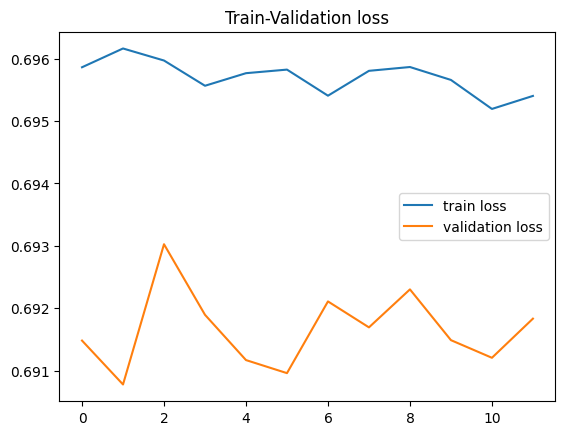

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935939377608615 	 Validation loss: 0.691894675715495 	 
  1%|          | 574/57400 [00:05<08:48, 107.62it/s]
Epoch 2 	 Training loss: 0.6933903966215845 	 Validation loss: 0.6922021114220054 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:38, 108.59it/s]
Epoch 3 	 Training loss: 0.6934411411501389 	 Validation loss: 0.6927699386063269 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:17<08:39, 107.17it/s]
Epoch 4 	 Training loss: 0.6933391709983971 	 Validation loss: 0.6919421462689416 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:23<08:30, 107.89it/s]
Epoch 5 	 Training loss: 0.6935549636958783 	 Validation loss: 0.6920770841129755 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:29<08:23, 108.23it/s]
Epoch 6 	 Training loss: 0.6935016716398844 	 Validation loss: 0.6918311129182072 	 
  6%|▌         | 3444/57400 [00:34<08:26, 106.46it/s]
Epoch 7 	 Training loss: 0.6933572668231738 	 Valida

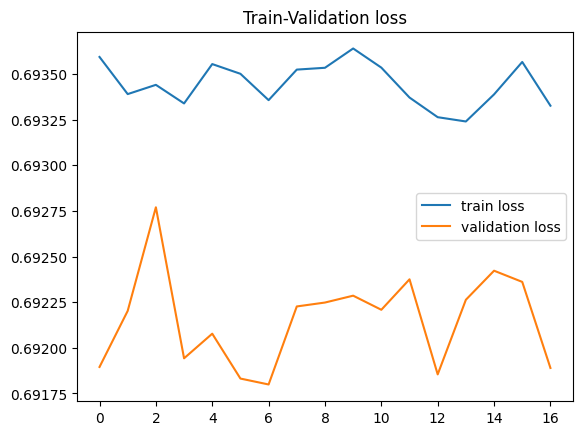

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5127551020408163, 'precision': 0.5127551020408163, 'f1': 0.5127551020408163, 'accuracy': 0.5127551020408163}
MALE {'recall': 0.005208333333333333, 'precision': 0.005208333333333333, 'f1': 0.005208333333333333, 'accuracy': 0.005208333333333333}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.004866180048661801, 'precision': 0.004866180048661801, 'f1': 0.004866180048661801, 'accuracy': 0.004866180048661801}
FEMALE {'recall': 0.9921259842519685, 'precision': 0.9921259842519685, 'f1': 0.9921259842519685, 'accuracy': 0.9921259842519685} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4758800521512386, 'precision': 0.4758800521512386, 'f1': 0.4758800521512386, 'accuracy': 0.4758800521512386}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695281153356572 	 Validation loss: 0.6915210253101284 	 
  1%|          | 574/57400 [00:05<08:59, 105.29it/s]
Epoch 2 	 Training loss: 0.6947052343797185 	 Validation loss: 0.6916795857882095 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:11<08:52, 105.60it/s]
Epoch 3 	 Training loss: 0.6949597650081023 	 Validation loss: 0.6905590214971769 	 
  3%|▎         | 1722/57400 [00:17<08:39, 107.13it/s]
Epoch 4 	 Training loss: 0.6951293955696585 	 Validation loss: 0.6920467211028277 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:23<08:40, 105.85it/s]
Epoch 5 	 Training loss: 0.6948129518106839 	 Validation loss: 0.6916369401802451 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:29<08:23, 108.31it/s]
Epoch 6 	 Training loss: 0.6946709149805926 	 Validation loss: 0.6912346492379399 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:34<08:22, 107.29it/s]
Epoch 7 	 Training loss: 0.6948344954630223 	 Valida

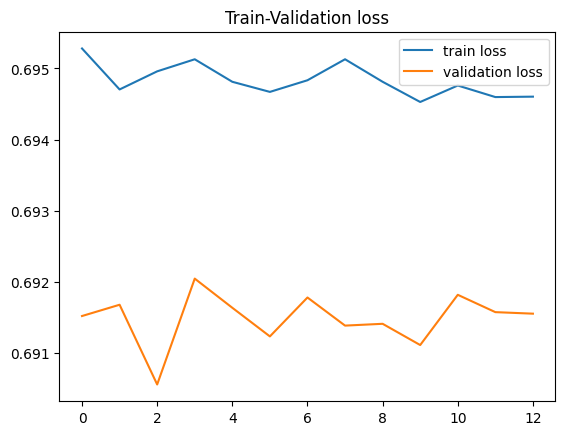

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5110544217687075, 'precision': 0.5110544217687075, 'f1': 0.5110544217687075, 'accuracy': 0.5110544217687075}
Métricas etiqueta male: {'recall': 0.001736111111111111, 'precision': 0.001736111111111111, 'f1': 0.001736111111111111, 'accuracy': 0.001736111111111111}
Métricas etiqueta female:  {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}

 to
Resultado global: {'recall': 0.48063973063973064, 'precision': 0.48063973063973064, 'f1': 0.48063973063973064, 'accuracy': 0.48063973063973064}
Métricas etiqueta male: {'recall': 0.0016220600162206002, 'precision': 0.0016220600162206002, 'f1': 0.0016220600162206002, 'accuracy': 0.0016220600162206002}
Métricas etiqueta female:  {'recall': 0.9973753280839895, 'precision': 0.9973753280839895, 'f1': 0.9973753280839895, 'accuracy': 0.9973753280839895}

 as
Resultado global: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.48109

# AS

In [31]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933901227932774 	 Validation loss: 0.6937222854565765 	 
  1%|          | 574/57400 [00:06<09:59, 94.74it/s]
Epoch 2 	 Training loss: 0.6932251640313178 	 Validation loss: 0.6927761122331781 	 
  2%|▏         | 1148/57400 [00:13<09:42, 96.55it/s]
Epoch 3 	 Training loss: 0.6931731294879515 	 Validation loss: 0.6925635267112215 	 
  3%|▎         | 1722/57400 [00:19<09:51, 94.19it/s]
Epoch 4 	 Training loss: 0.6930306282816033 	 Validation loss: 0.6932453816219911 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:43, 94.40it/s]
Epoch 5 	 Training loss: 0.6930906725885145 	 Validation loss: 0.6926576363838325 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:29, 95.75it/s]
Epoch 6 	 Training loss: 0.6931455416754148 	 Validation loss: 0.693476691084393 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:39<09:15, 97.17it/s]
Epoch 7 	 Training loss: 0.6928643310111574 	 Validation loss: 0.6934510530051539 	 

4

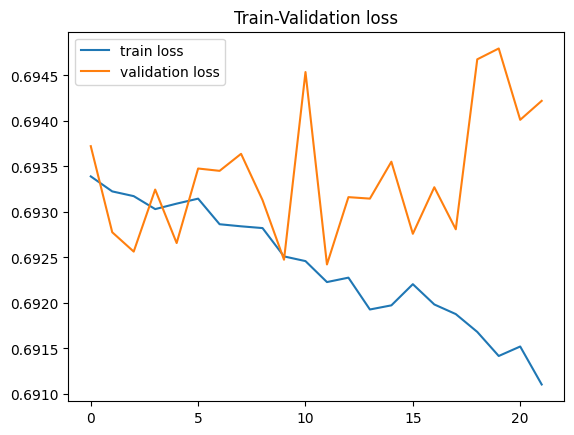

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5204081632653061, 'precision': 0.5204081632653061, 'f1': 0.5204081632653061, 'accuracy': 0.5204081632653061}
MALE {'recall': 0.328125, 'precision': 0.328125, 'f1': 0.328125, 'accuracy': 0.328125}
FEMALE {'recall': 0.705, 'precision': 0.705, 'f1': 0.705, 'accuracy': 0.705} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5088383838383839, 'precision': 0.5088383838383839, 'f1': 0.5088383838383839, 'accuracy': 0.5088383838383839}
MALE {'recall': 0.3381995133819951, 'precision': 0.3381995133819951, 'f1': 0.3381995133819951, 'accuracy': 0.3381995133819951}
FEMALE {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5449804432855281, 'precision': 0.5449804432855281, 'f1': 0.5449804432855281, 'accuracy': 0.5449804432855281}
MALE {'recall': 0.3838383838383838, 'precision': 0.383838383

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933867527425082 	 Validation loss: 0.6931981616101023 	 
  1%|          | 574/57400 [00:06<09:59, 94.77it/s]
Epoch 2 	 Training loss: 0.6932818180384952 	 Validation loss: 0.6933335490145925 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<09:41, 96.70it/s]
Epoch 3 	 Training loss: 0.6930837585535614 	 Validation loss: 0.6925163511502541 	 
  3%|▎         | 1722/57400 [00:19<09:46, 94.94it/s]
Epoch 4 	 Training loss: 0.6930020473352293 	 Validation loss: 0.6924505789401167 	 
  4%|▍         | 2296/57400 [00:26<09:40, 94.99it/s]
Epoch 5 	 Training loss: 0.692939790491443 	 Validation loss: 0.6938558412810504 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:39, 94.02it/s]
Epoch 6 	 Training loss: 0.6929392498960063 	 Validation loss: 0.6930144540334152 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:39<09:25, 95.34it/s]
Epoch 7 	 Training loss: 0.692853411004103 	 Validation loss: 0.6932442208467904 	 

3 

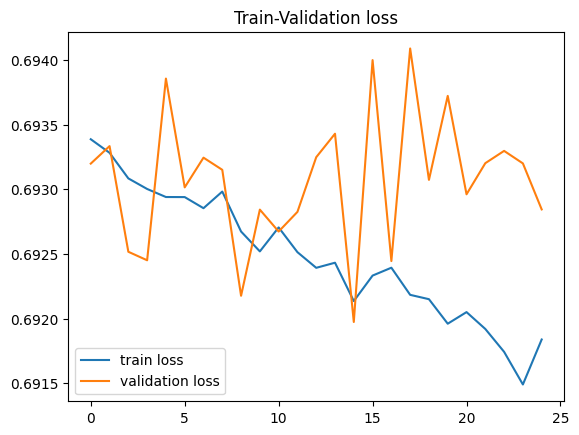

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5471938775510204, 'precision': 0.5471938775510204, 'f1': 0.5471938775510204, 'accuracy': 0.5471938775510204}
MALE {'recall': 0.5208333333333334, 'precision': 0.5208333333333334, 'f1': 0.5208333333333334, 'accuracy': 0.5208333333333334}
FEMALE {'recall': 0.5725, 'precision': 0.5725, 'f1': 0.5725, 'accuracy': 0.5725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5416666666666666, 'precision': 0.5416666666666666, 'f1': 0.5416666666666666, 'accuracy': 0.5416666666666666}
MALE {'recall': 0.46958637469586373, 'precision': 0.46958637469586373, 'f1': 0.46958637469586373, 'accuracy': 0.46958637469586373}
FEMALE {'recall': 0.6194225721784777, 'precision': 0.6194225721784777, 'f1': 0.6194225721784777, 'accuracy': 0.6194225721784777} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5423728813559322, 'precision': 0.5423728813559322, 'f1': 0.5423728813559322, 'accuracy': 0.5423728813559322}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932826773214839 	 Validation loss: 0.692391369302394 	 
  1%|          | 574/57400 [00:06<10:11, 92.99it/s]
Epoch 2 	 Training loss: 0.6931312963729952 	 Validation loss: 0.6927629860781007 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<09:42, 96.57it/s]
Epoch 3 	 Training loss: 0.6929338215120163 	 Validation loss: 0.6923096321396909 	 
  3%|▎         | 1722/57400 [00:19<09:48, 94.64it/s]
Epoch 4 	 Training loss: 0.6930100993619979 	 Validation loss: 0.6936738592083171 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:34, 95.93it/s]
Epoch 5 	 Training loss: 0.6930463713843648 	 Validation loss: 0.692533707214614 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:41, 93.74it/s]
Epoch 6 	 Training loss: 0.6930224867440267 	 Validation loss: 0.6921133661674241 	 
  6%|▌         | 3444/57400 [00:39<09:37, 93.40it/s]
Epoch 7 	 Training loss: 0.6929651578752006 	 Validation loss: 0.6937227905806849 	 

1 

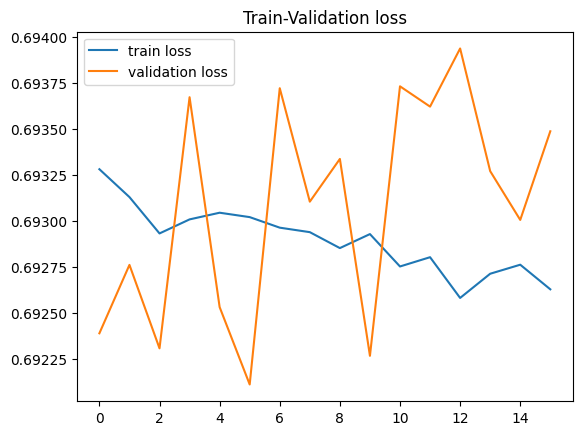

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
MALE {'recall': 0.1875, 'precision': 0.1875, 'f1': 0.1875, 'accuracy': 0.1875}
FEMALE {'recall': 0.81, 'precision': 0.81, 'f1': 0.81, 'accuracy': 0.81} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5050505050505051, 'precision': 0.5050505050505051, 'f1': 0.5050505050505051, 'accuracy': 0.5050505050505051}
MALE {'recall': 0.18004866180048662, 'precision': 0.18004866180048662, 'f1': 0.18004866180048662, 'accuracy': 0.18004866180048662}
FEMALE {'recall': 0.8556430446194225, 'precision': 0.8556430446194225, 'f1': 0.8556430446194225, 'accuracy': 0.8556430446194225} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4758800521512386, 'precision': 0.4758800521512386, 'f1': 0.4758800521512386, 'accuracy': 0.4758800521512386}
MALE {'recall': 0.15656565656565657, 'precision': 0.1565656565656565

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5242346938775511, 'precision': 0.5242346938775511, 'f1': 0.5242346938775511, 'accuracy': 0.5242346938775511}
Métricas etiqueta male: {'recall': 0.3454861111111111, 'precision': 0.3454861111111111, 'f1': 0.3454861111111111, 'accuracy': 0.3454861111111111}
Métricas etiqueta female:  {'recall': 0.6958333333333333, 'precision': 0.6958333333333333, 'f1': 0.6958333333333333, 'accuracy': 0.6958333333333333}

 to
Resultado global: {'recall': 0.5185185185185185, 'precision': 0.5185185185185185, 'f1': 0.5185185185185185, 'accuracy': 0.5185185185185185}
Métricas etiqueta male: {'recall': 0.3292781832927818, 'precision': 0.3292781832927818, 'f1': 0.3292781832927818, 'accuracy': 0.3292781832927818}
Métricas etiqueta female:  {'recall': 0.7226596675415573, 'precision': 0.7226596675415573, 'f1': 0.7226596675415573, 'accuracy': 0.7226596675415573}

 as
Resultado global: {'recall': 0.5210777922642329, 'precision': 0.5210777922642329, 'f1': 0.5